### Homework 5: FX Carry Strategy - Hengxu Zhu 12368409

## Import Packages

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import scipy as sp
import functools
import quandl
import seaborn as sns
import plotnine as p9
import datetime
from statsmodels.tsa.ar_model import AutoReg 
import warnings 
from datetime import datetime
from datetime import timedelta
warnings.filterwarnings('ignore')

## Load Data

In [2]:
quandl.ApiConfig.api_key = '_MNv7zC_784tGzbfxhxP' 

In [3]:
uk_issc = quandl.get('YC/GBR_ISSC',returns="pandas")
uk_issc = uk_issc[['0.08Y']]   
uk_isss = quandl.get('YC/GBR_ISSS', returns="pandas")
uk_isss = uk_isss[['0.08Y']]
uk_ois = pd.concat([uk_issc,uk_isss]).drop_duplicates() 
gbp_rate = quandl.get('CUR/GBP') 

In [4]:
vnd_rate = quandl.get('CUR/VND')  
thb_rate = quandl.get('CUR/THB')  
pkr_rate = quandl.get('CUR/PKR')  
php_rate = quandl.get('CUR/PHP')  

In [5]:
vnd_yield = quandl.get('YC/VNM')  
thb_yield = quandl.get('YC/THA') 
pkr_yield = quandl.get('YC/PAK') 
php_yield = quandl.get('YC/PHL')

## Implement Strategy

The strategy implementation consists of several steps for each currency: 
1. Use the functions in 'Zero_And_Spot_Curves' to convert the Spot rates from Quandl to Zero rates. 
2. Utilize the converted Zero rates curve and the 5-Year Swap rate (as the Coupon rate) to calculation the bond price for each week. 
3. Calculate the PnL of the Lending Currency using the formula from the lecture (where N is notional and f is exchange rate): 

$$ N \times (\frac{bond price^{new}}{bond price^{old}} \times \frac{f^{old}}{f^{new}}-1)$$ 

4. Calculate the PnL of the Borrowing Currency using the formula from the lecture (where B is borrowing amount and): 

$$ B \times (1-{e^{OIS+50bp}}) $$ 

Although the formulas are essentially derived from lecture, we still did some other manipulation as the bond discussed in the class is continuously compouded without coupon payment, we need to include the coupon and convert the spot rate accordingly before calculating the PnLs.

We start by calculating the Zero Rates.

In [6]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve]
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                times = np.arange(tenor-0.25, 0, step=-0.25)[::-1]
                coupon_quarter = 0.25*spot_rate
                z = np.interp(times, zcb_rates[curve].index.values, zcb_rates[curve].values) # Linear interpolation
                preceding_coupons_val = (coupon_quarter*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon_quarter))/tenor
    return zcb_rates

def bond_price(zcb, coupon_rate, tenor):
    times = np.arange(tenor, 0, step=-0.5)[::-1]
    if times.shape[0]==0:
        p = 1.0
    else:
        r = np.interp(times, zcb.index.values, zcb.values) # Linear interpolation
        p = np.exp(-tenor*r[-1]) + 0.5 * coupon_rate * np.exp(-r*times).sum()
    return p

def df_bond(lend_yield): 
    rates = pd.DataFrame({'Rate':lend_yield,
                     'Tenor':[1,2,3,5]}).set_index(['Tenor'])  
    zcb = compute_zcb_curve(rates) 
    return bond_price(zcb['Rate'], rates['Rate'][3], tenor=5)

def lend_bond_price(lend_yield): 
    df = lend_yield[['1-Year','2-Year','3-Year','5-Year']].rename(columns={'1-Year': 'Lend_1Y',
                                                                           '2-Year': 'Lend_2Y',
                                                                           '3-Year': 'Lend_3Y',
                                                                           '5-Year': 'Lend_5Y'}) 
    df = df/100 
    df = df.resample('7D').asfreq() 
    df = df.fillna(method='ffill') 
    df['Bond_Price'] = df.apply(df_bond, axis='columns')
    return df

After calculating the Zero rates, we can assumble the table with UK OIS, UK Exchange Rate, Lending Currency Swap Rate and Lending Currency Exchange Rate. 

In [7]:
def setup_df(uk_ois, uk_rate, lend_yield, lend_rate): 
    
    df = lend_bond_price(lend_yield)
    
    df = df.join(lend_rate).rename(columns={'RATE': 'Lend_Rate'}) 
    
    df = df.join(uk_ois).rename(columns={'0.08Y': 'OIS'}) 
    df['OIS'] = df['OIS']/100
    df = df.join(uk_rate).rename(columns={'RATE': 'UK_Rate'})
    
    df = df.fillna(method='ffill') 
    
    df['Exchange_Rate'] = df['Lend_Rate']/df['UK_Rate'] 
    df = df.drop(columns=['Lend_Rate', 'UK_Rate', 'Lend_1Y', 'Lend_2Y', 'Lend_3Y']) 
    
    return df

After setting up the table, we can start calculating the PnL using the formulas derived from our lecture. 

In [8]:
def pnl(uk_ois, gbp_rate, lend_yield, lend_rate): 
    notional = 10 * 10**6 
    borrowing = 8 * 10**6 
    
    df = setup_df(uk_ois, gbp_rate, lend_yield, lend_rate)
    
    df['Bond_Price_Old'] = df['Bond_Price'].shift() 
    df['Bond_Price_New'] = df['Bond_Price'] 
    df = df.drop(columns=['Bond_Price'])
    df['Exchange_Rate_Old'] = df['Exchange_Rate'].shift()  
    df['Exchange_Rate_New'] = df['Exchange_Rate'] 
    df = df.drop(columns=['Exchange_Rate'])
    df = df.dropna() 
    
    df['Trigger'] = np.where(df['Lend_5Y']-df['OIS'] < 0.005, 0, 1)

    df['PnL_Lending'] = df['Trigger'] * (notional * (df['Bond_Price_New'] / df['Bond_Price_Old']) 
                                         * (df['Exchange_Rate_Old'] / df['Exchange_Rate_New']) - notional)
    df['PnL_Borrowing'] = df['Trigger'] * (borrowing - borrowing * np.exp(df['OIS']/52))
    
    df = df[['PnL_Lending', 'PnL_Borrowing']] 
    df['PnL'] = df['PnL_Lending'] + df['PnL_Borrowing'] 
    df['cum_PnL_Lending'] = df['PnL_Lending'].cumsum()
    df['cum_PnL_Borrowing'] = df['PnL_Borrowing'].cumsum() 
    df['cum_PnL'] = df['cum_PnL_Lending'] + df['cum_PnL_Borrowing']
    
    return df

## Plot Graphs of Cumulative PnL and Return 

In [9]:
vnd = pnl(uk_ois, gbp_rate, vnd_yield, vnd_rate)
vnd.head()

,PnL_Lending,PnL_Borrowing,PnL,cum_PnL_Lending,cum_PnL_Borrowing,cum_PnL
Date,,,,,,
2014-12-08,83997.809105,-658.234956,83339.574149,83997.809105,-658.234956,83339.574149
2014-12-15,-845.851087,-654.910387,-1500.761475,83151.958018,-1313.145343,81838.812675
2014-12-22,4420.462653,-657.347094,3763.115559,87572.420671,-1970.492437,85601.928233
2014-12-29,43709.056474,-660.785144,43048.271331,131281.477145,-2631.277581,128650.199564
2015-01-05,101080.699586,-663.005220,100417.694366,232362.176731,-3294.282801,229067.893930


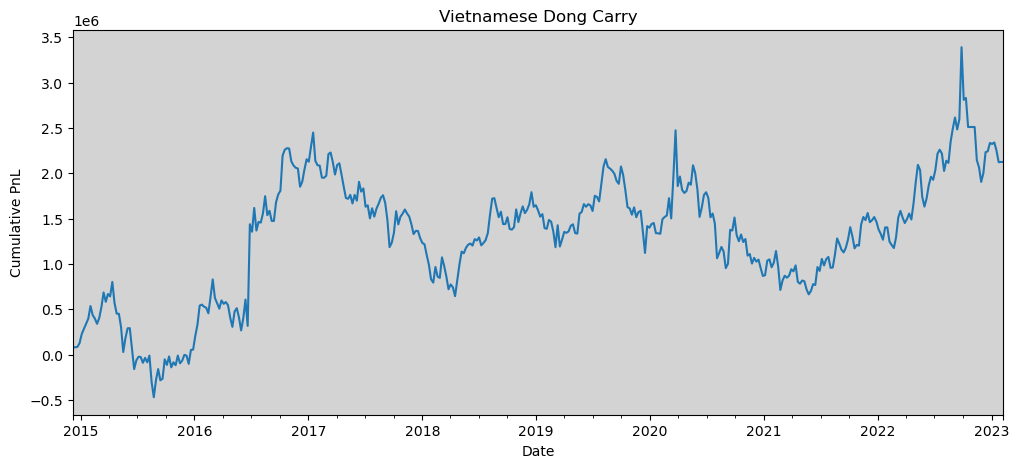

In [10]:
vnd['cum_PnL'].plot(title= "Vietnamese Dong Carry", ylabel = "Cumulative PnL", xlabel = "Date", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

In [11]:
thb = pnl(uk_ois, gbp_rate, thb_yield, thb_rate)
thb.head()

,PnL_Lending,PnL_Borrowing,PnL,cum_PnL_Lending,cum_PnL_Borrowing,cum_PnL
Date,,,,,,
2014-12-08,-43370.509721,-658.234956,-44028.744676,-43370.509721,-658.234956,-44028.744676
2014-12-15,94661.505720,-654.910387,94006.595333,51290.995999,-1313.145343,49977.850656
2014-12-22,74611.777007,-657.347094,73954.429912,125902.773006,-1970.492437,123932.280569
2014-12-29,24350.830268,-660.785144,23690.045124,150253.603274,-2631.277581,147622.325693
2015-01-05,171928.428525,-663.005220,171265.423306,322182.031800,-3294.282801,318887.748999


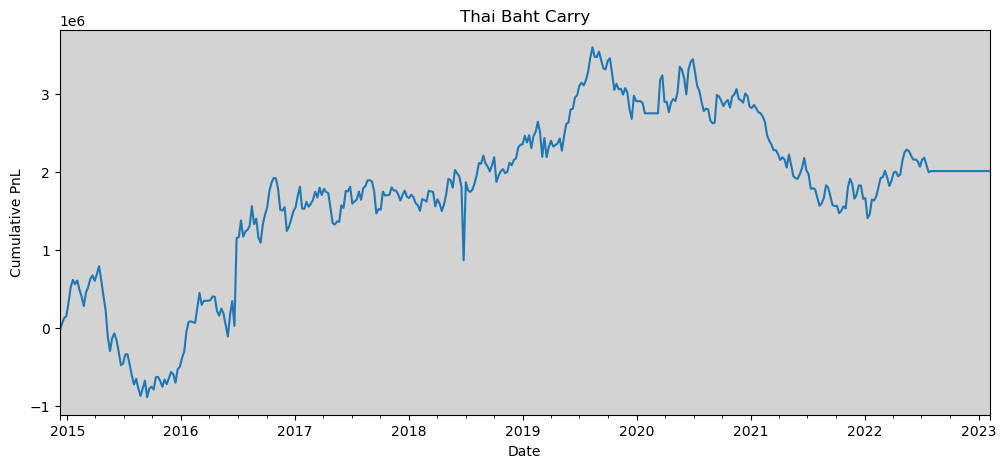

In [12]:
thb['cum_PnL'].plot(title= "Thai Baht Carry", ylabel = "Cumulative PnL", xlabel = "Date", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray') 

In [13]:
php = pnl(uk_ois, gbp_rate, php_yield, php_rate)
php.head()

,PnL_Lending,PnL_Borrowing,PnL,cum_PnL_Lending,cum_PnL_Borrowing,cum_PnL
Date,,,,,,
2014-12-08,145107.143995,-658.234956,144448.909040,145107.143995,-658.234956,144448.909040
2014-12-15,-3877.201641,-654.910387,-4532.112029,141229.942354,-1313.145343,139916.797011
2014-12-22,119124.565325,-657.347094,118467.218231,260354.507678,-1970.492437,258384.015241
2014-12-29,30399.384863,-660.785144,29738.599719,290753.892541,-2631.277581,288122.614960
2015-01-05,170101.704695,-663.005220,169438.699476,460855.597237,-3294.282801,457561.314436


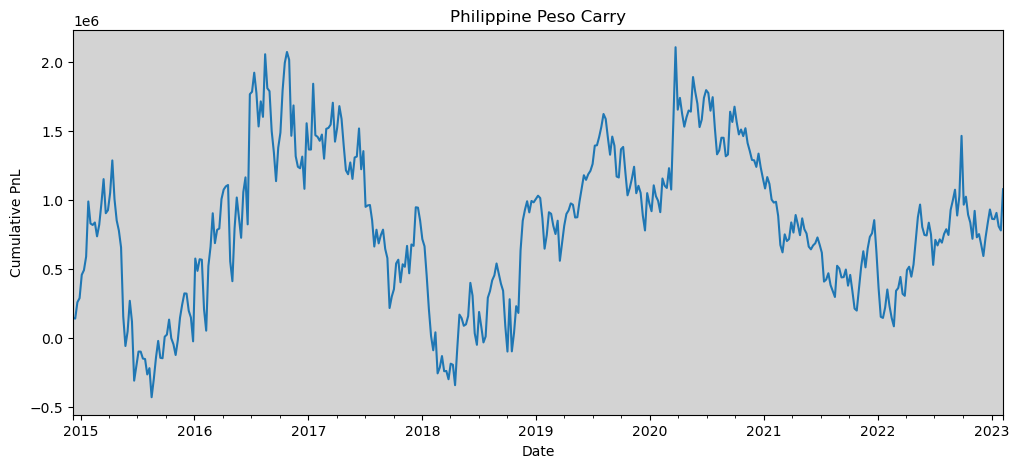

In [14]:
php['cum_PnL'].plot(title= "Philippine Peso Carry", ylabel = "Cumulative PnL", xlabel = "Date", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

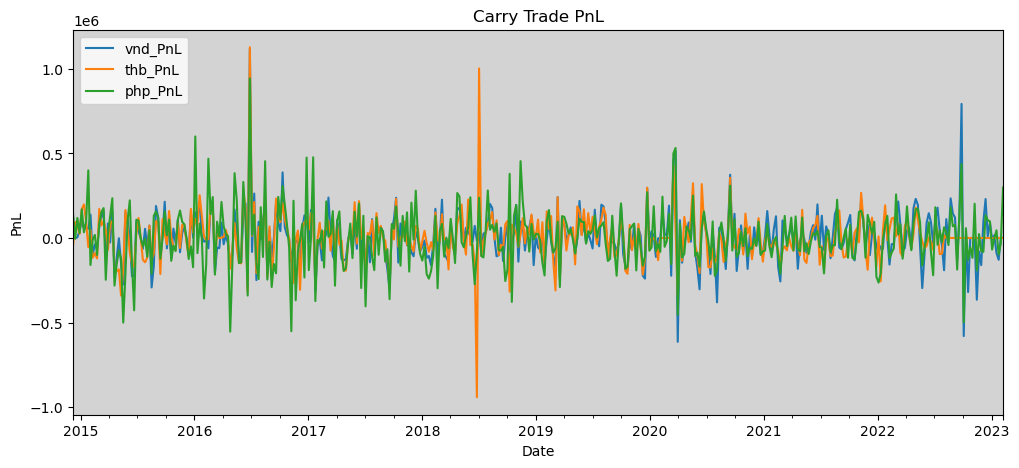

In [15]:
pnl = vnd[['PnL']].rename(columns={'PnL': 'vnd_PnL'})
pnl = pnl.join(thb['PnL']).rename(columns={'PnL': 'thb_PnL'})
pnl = pnl.join(php['PnL']).rename(columns={'PnL': 'php_PnL'}) 
pnl.plot(title= "Carry Trade PnL", ylabel = "PnL", xlabel = "Date", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

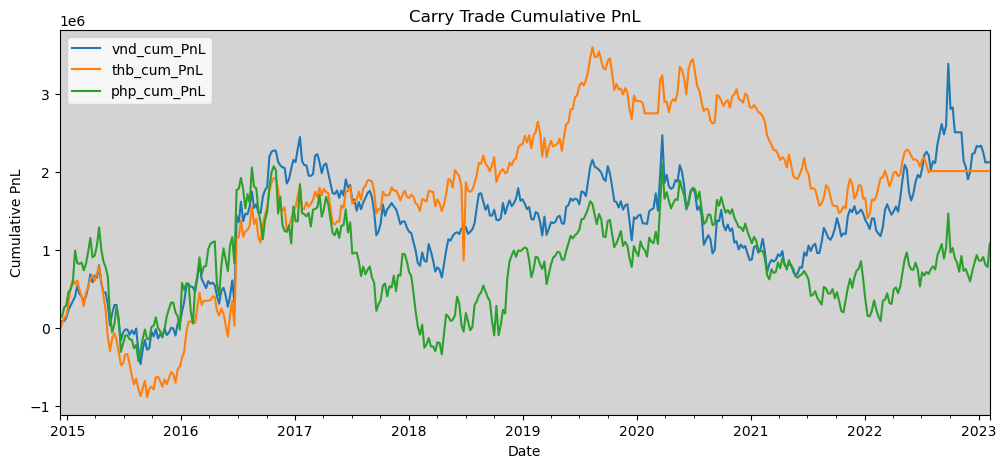

In [16]:
cum_pnl = vnd[['cum_PnL']].rename(columns={'cum_PnL': 'vnd_cum_PnL'})
cum_pnl = cum_pnl.join(thb['cum_PnL']).rename(columns={'cum_PnL': 'thb_cum_PnL'})
cum_pnl = cum_pnl.join(php['cum_PnL']).rename(columns={'cum_PnL': 'php_cum_PnL'})
cum_pnl.plot(title= "Carry Trade Cumulative PnL", ylabel = "Cumulative PnL", xlabel = "Date", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

In [17]:
ret = pnl / (2 * 10**6) 
ret = ret.rename(columns={'vnd_PnL': 'vnd_return', 'thb_PnL': 'thb_return', 'php_PnL': 'php_return'}) 
cum_ret = (1+ret).cumprod() - 1

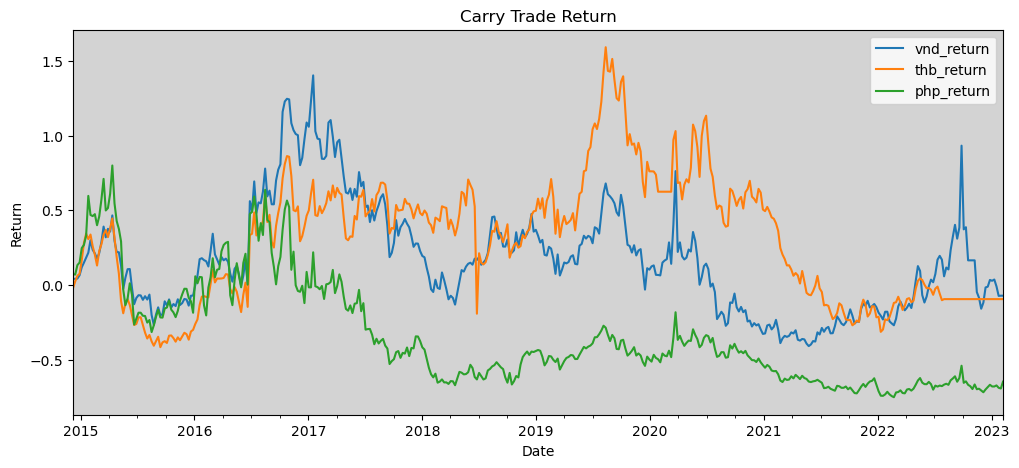

In [18]:
cum_ret.plot(title= "Carry Trade Return", ylabel = "Return", xlabel = "Date", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray')

## Analysis On Strategy Performance

In [19]:
def performance_summary(return_data):
    
    summary_stats = return_data.mean().to_frame('Return').apply(lambda x: x*52)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(52))
    summary_stats['Sharpe Ratio'] = summary_stats['Return']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    return summary_stats

In [20]:
performance_summary(ret[['vnd_return']])

,Return,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom
vnd_return,0.129369,0.534408,0.242078,1.074878,9.849731,-0.105986,-0.151232,-0.307101,0.559847,-0.754426,2017-01-16,2021-05-24


In [21]:
performance_summary(ret[['thb_return']])

,Return,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom
thb_return,0.122465,0.522356,0.234448,1.150797,16.883508,-0.096812,-0.144395,-0.470972,0.564188,-0.735483,2019-08-12,2022-01-10


In [22]:
performance_summary(ret[['php_return']])

,Return,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom
php_return,0.065668,0.623609,0.105304,0.415853,2.850033,-0.126147,-0.184112,-0.277131,0.472019,-0.862366,2015-04-13,2022-02-21


From the performance metrics, we can observe that doing carry trade with Vietnamese Dong gives the best performance. It has the best return as well as the best Sharpe Ratio. 

Its skewness and kurtosis are not as good as Philippine Peso, but since its annualized return is the worst, we should still focus on the Vietnamese Dong. 

However, when we move on to the Value-at-Risk, we can see that Thai Baht has the best performance as it gives the smallest window to have a loss. However, this might be caused by a large kurtosis, as the large kurtosis will reduce the tail weights. 

From the Max Drawdown, we can see that Philippine Peso still has the worst performance as it has the worst drop during this period. However, from the graph, we may see that Philippine Peso actually have a overall stable return, but mostly the cumulative return is negative. 

From all the metrics, we know that we should not choose Philippine Peso if we have other options. However, if we have to choose between Vietnamese Dong and Thai Baht, I would recommend Vietnamese Dong based on 2 reasons. Firstly, its bottom point is in 2021 while Thai Baht is in 2022. Thai Baht performs worse during the most recent period. Secondly, Thai Baht cannot even excute any trade for the most recent period as its 5Y swap rate is less than 50bp higher than the 5Y swap rate in British Pound. In conclusion, Vietnamese Dong is the best carry trade currency in our simulation.

## Conclusion 

After evaluating the simulation process, I think there are ways to make this Carry Strategy better. Firstly, if we know which one of the three currencies will perform well, we can choose that one to trade for that specific week. The resulting Cumulative PnL will be extremely good. However, since the Carry Trade requires the new bond price and new exchange rate to calculate the PnL, there is no way that we know which one of these currencies will perform well at the beginning of each week. Therefore, this is not something we can do in reality. 

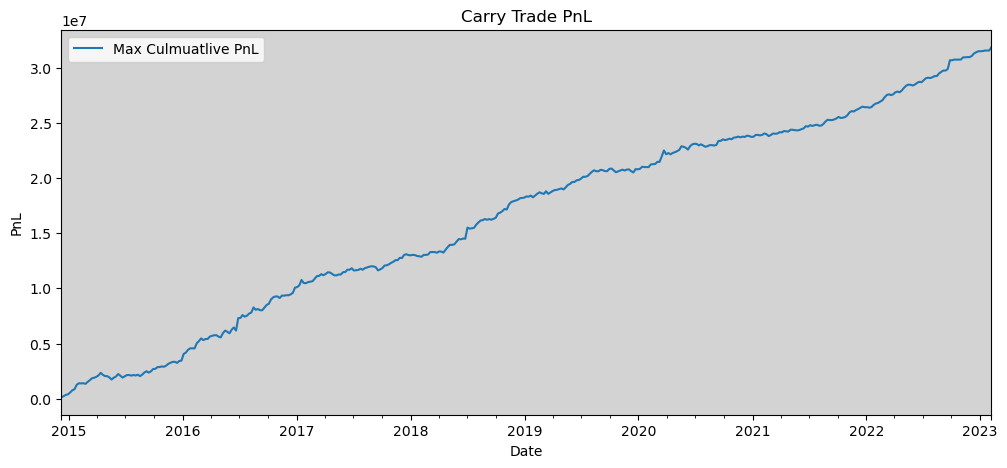

In [23]:
pnl['max'] = pnl.max(axis=1)
pnl['Max Culmuatlive PnL'] = pnl['max'].cumsum() 
pnl[['Max Culmuatlive PnL']].plot(title= "Carry Trade PnL", ylabel = "PnL", xlabel = "Date", figsize = (12,5),style='-');
plt.gca().set_facecolor('lightgray') 

On the other hand, if I can do this project again, I will try to use different borrowing currencies. This may be helpful to seek for a more beneficial return from different combinations of currencies. For example, we can try to use US exchange rate to these lending currencies and use SOFR as the swap rate to perform similar strategy implementation, and then analyze the new returns. 